In [216]:
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats import diagnostic
from scipy import stats

## 1. Data loading

In [217]:
with gzip.open('../data/wiki-RfA.txt.gz', 'rt', encoding='utf-8') as f:
    blocks = f.read().strip().split('\n\n')  # Assuming each record is separated by a blank line

data = []

# Parse each block of text into a dictionary
for block in blocks:
    record = {}
    for line in block.split('\n'):
        if line:
            key, value = line.split(':', 1)  # Split on the first colon only
            record[key.strip()] = value.strip()
    data.append(record)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

#Rename the columns
df.columns = ['source', 'target', 'vote', 'result', 'year_election', 'date_vote', 'comment']

In [218]:
df

,source,target,vote,result,year_election,date_vote,comment
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.
198272,Jiang,WhisperToMe,1,1,2003,,Support. --
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....


## 2. Preliminary checks

In [273]:
#Create a new dataframe before cleaning the data
new_df = df.copy(deep=True)

### 2.1 Dive into user name source

In [274]:
#Transform the source column to string
source_cleaned_data = new_df.copy(deep=True)
source_cleaned_data['source'] = source_cleaned_data['source'].astype(str)

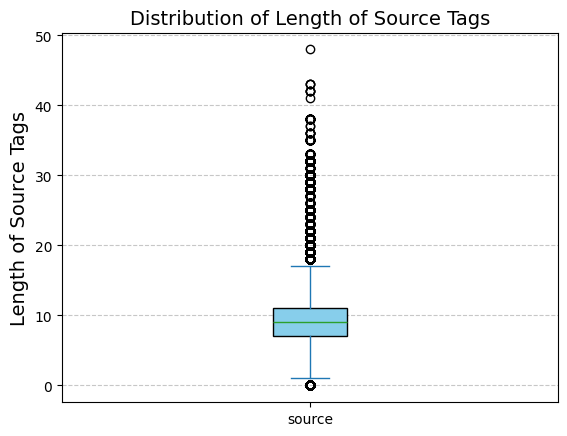

In [275]:
#Look at the distribution of the length of the source tags with a box plot
ax = source_cleaned_data['source'].str.len().plot(kind='box', patch_artist=True, boxprops=dict(facecolor='skyblue'))
ax.set_title('Distribution of Length of Source Tags', fontsize=14)
ax.set_ylabel('Length of Source Tags', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [277]:
#Look at the number of unique source users
unique_voters = source_cleaned_data['source'].nunique()
print(f'The number of unique voters is {unique_voters}')

#Look at the number of null values for the source
nan_source = source_cleaned_data[source_cleaned_data.source == '']['source'].count()
print(f'The number of voters without tags is {nan_source}')

The number of unique voters is 10417
The number of voters without tags is 1661


While examining the outliers in relation to their source tags:
- It's observed that outliers possessing source tags longer than 25 characters typically do not present specific issues.
- A significant portion of these outliers are identified to have empty source tag lengths. Consequently, we've opted to exclude votes linked with empty source tags. This decision aligns with our objective to utilize the data for community building and to track user interactions. Allowing votes from empty source tags might skew our community analysis, potentially leading to an imbalance where certain users' votes are disproportionately influential compared to others.

In [278]:
#Remove the rows with votes associated to empty source 
source_cleaned_data = source_cleaned_data[source_cleaned_data.source != '']

In [279]:
#Now we look at the other outliers, votes with user tags of length greater than 200
source_cleaned_data[source_cleaned_data.source.str.len() > 20].source.unique()


array(['Pharaoh of the Wizards', "Useight's Public Sock",
       'Brambleberry of RiverClan', 'Sir Nicholas de Mimsy-Porpington',
       'Hullaballoo Wolfowitz', 'The Blade of the Northern Lights',
       'Gareth Griffith-Jones', 'Santa Claus of the Future',
       'You Can Act Like A Man', 'Future Perfect at Sunrise',
       'Lothar von Richthofen', 'GMolewaterdelaRiveBox',
       "Chase me ladies, I'm the Cavalry",
       'Short Brigade Harvester Boris', 'Rannpháirtí anaithnid',
       'Alessandra Napolitano', "Floquenstein's monster",
       'Thine Antique Pen (public)',
       'Department of Redundancy Department', 'Regent of the Seatopians',
       'Catfish Jim and the soapdish', 'Who Am I Why Am I Here',
       'ResidentAnthropologist', 'Physics is all gnomes',
       'DisillusionedBitterAndKnackered', 'PrincessWortheverything',
       'Planetary Chaos Redux', 'The most interesting man in the world',
       'Another Type of Zombie', 'SomeDudeWithAUserName',
       'The High Fin S

Usernames appear accurate and suitable for user tags, and thus do not require removal.

### 2.2 Dive into target user name 

In [236]:
#Make deep copy before cleaning for target
target_cleaned_data = source_cleaned_data.copy(deep=True)

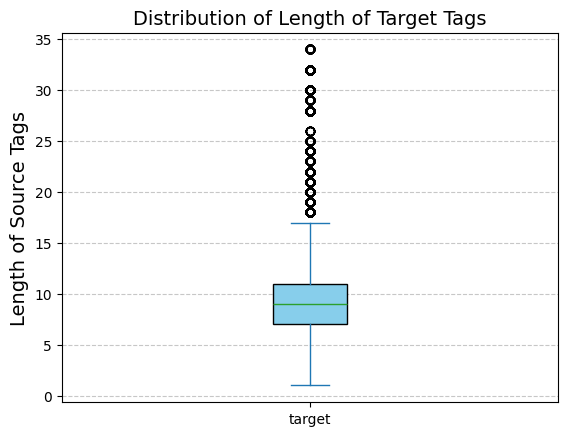

In [239]:
#Look at the distribution of the length of the target tags with a box plot
ax = target_cleaned_data['target'].str.len().plot(kind='box', patch_artist=True, boxprops=dict(facecolor='skyblue'))
ax.set_title('Distribution of Length of Target Tags', fontsize=14)
ax.set_ylabel('Length of Source Tags', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [240]:
#Look at the number of unique target users
unique_electives = target_cleaned_data['target'].nunique()
print(f'The number of unique users running for election is {unique_electives}')

#Look at the number of null values for the source
nan_target = target_cleaned_data[target_cleaned_data.target == '']['target'].count()
print(f'The number of nan values for the target is {nan_target}')

The number of unique users running for election is 3491
The number of nan values for the source is 0


In [250]:
new_df[new_df.target.str.len() > 20].target.unique()

array(['Catfish Jim and the soapdish', 'Rannpháirtí anaithnid',
       'The Blade of the Northern Lights', 'Who Am I Why Am I Here',
       'Marcus Aurelius Antoninus', 'PopMusicWillNeverBeLowBrow',
       'RandomStringOfCharacters', 'The High Fin Sperm Whale',
       'The Thing That Should Not Be', 'Wiki Greek Basketball',
       'Backslash Forwardslash', 'Alexander.hugh.george',
       'I Seek To Help & Repair!', 'Raiku Lucifer Samiyaza',
       'The Black Rabbit of Inlé', 'crimsonterminator1000',
       'How do you turn this on', 'Imperial Star Destroyer',
       'Inferno, Lord of Penguins', 'Joseph Solis in Australia',
       'Jupiter Optimus Maximus', "Milk's Favorite Cookie",
       "Sock's Favorite Puppet", 'The Great Editor In Chief',
       'WeBuriedOurSecretsInTheGarden',
       "Chase me ladies, I'm the Cavalry", 'Faithlessthewonderboy',
       'Jaranda (reconfirmation)', 'A Raider Like Indiana',
       'Ineversigninsodonotmessageme', 'SpecialAgentUncleTito',
       "The Rav

Usernames appear accurate and suitable for user tags, and thus do not require removal.

### 2.3 Check the date and time of votes : 

In [331]:
date_cleaned_data = target_cleaned_data.copy(deep=True)

In [332]:
# Define a function to extract date components
def extract_date_components(date_str):
    try:
        # Split the date string by the comma and space to separate time and date parts
        time_part, date_part = date_str.split(', ')
        # Split the time part by the colon to separate hours and minutes
        hour, minute = time_part.split(':')
        # Split the date part by space to separate day, month, and year
        day, month, year = date_part.split(' ')
        
        return pd.Series({
            "hour": hour,
            "minute": minute,
            "day": day,
            "month": month,
            "year_vote": year
        })
    except ValueError:
        # If there is a ValueError, return None for each component
        return pd.Series({
            "hour": None,
            "minute": None,
            "day": None,
            "month": None,
            "year_vote": None
        })

# Apply the function to each row in the 'date' column
date_components = date_cleaned_data['date_vote'].apply(extract_date_components)

# Concatenate the new DataFrame with the original one (if needed)
date_cleaned_data = pd.concat([date_cleaned_data, date_components], axis=1)

date_cleaned_data

In [328]:
#Look at the proportion of rows with missing date_vote
non_date_votes = date_cleaned_data[date_cleaned_data.date_vote == ''].date_vote.count()
total_count = date_cleaned_data.date_vote.count()
print(f'The number of votes for which the date is missing or incorrect is {non_date_votes}')
print(f'This represents {(non_date_votes/total_count)*100:.2f}% of the data.')

The number of votes for which the date is missing or incorrect is 0
This represents 0.00% of the data.


In [329]:
#Remove the rows with missing date_vote
date_cleaned_data = date_cleaned_data[date_cleaned_data.date_vote != '']

In [330]:
#Look at the distribution for the values of the hour with histogram
date_cleaned_data['hour'].value_counts().sort_index().plot(kind='bar' , color = 'teal' ,  edgecolor='black')
plt.xlabel('Hour the vote was cast')
plt.ylabel('Number of votes cast')
# Set a grid for easier reference to the quantities
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Distribution of votes by hour of day')
plt.show()

KeyError: 'hour'

In [282]:
#Proportion of rows with the hour value as 31
print(f'The proportion of rows with the hour value as 31 is {date_cleaned_data[date_cleaned_data.hour == "31"]["hour"].count()/date_cleaned_data["hour"].count()}')

The proportion of rows with the hour value as 31 is 5.293582061109111e-06


In this dataset, there is a record of a vote occurring at the 31st hour, which is not a valid time. Given that the number of occurrences is negligible, we have chosen to exclude this data point from the dataframe. This removal is unlikely to affect the overall analysis of the dataset due to its minimal incidence.

In [285]:
#Remove from the dataframe the rows with the value of the hour as 31
date_cleaned_data = date_cleaned_data[date_cleaned_data['hour'] != '31']

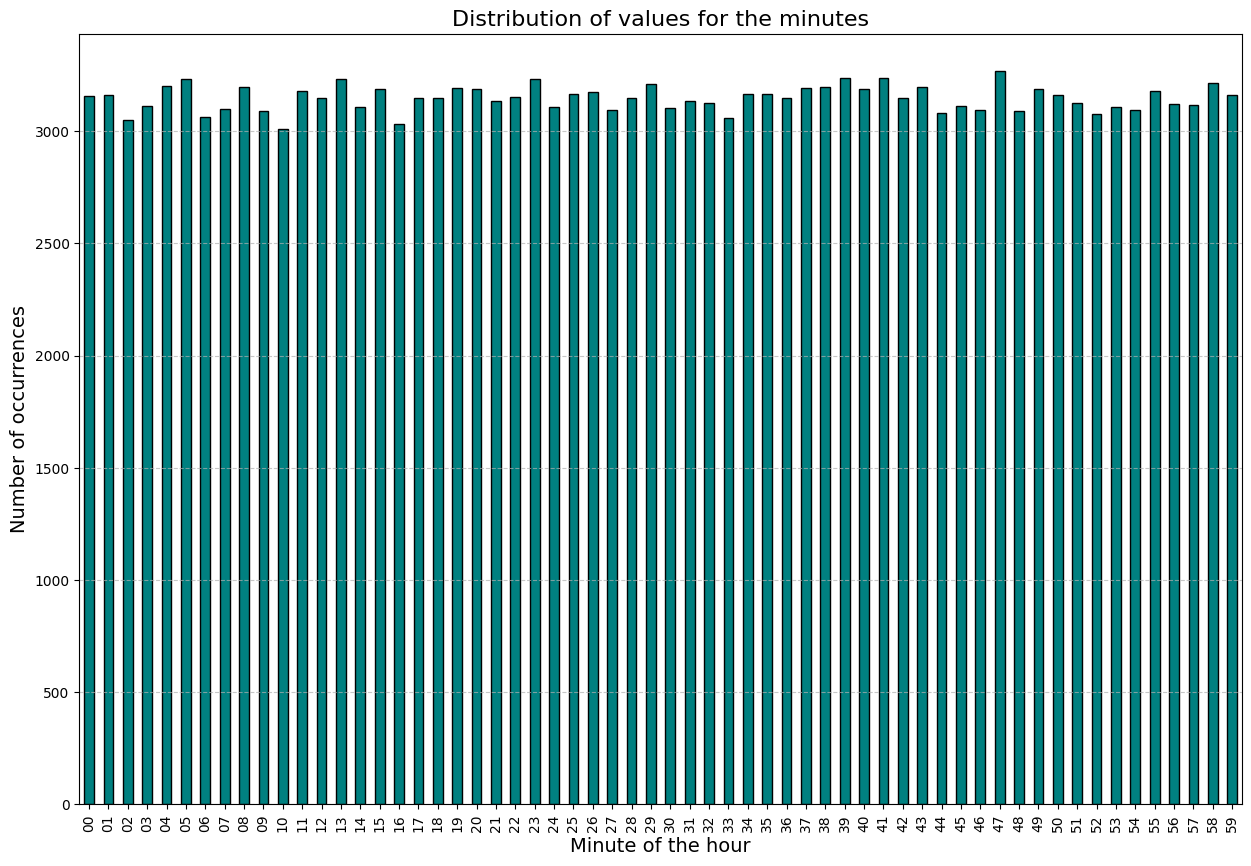

In [286]:
# Set the figure size for better visibility
plt.figure(figsize=(15, 10))

ax = date_cleaned_data['minute'].value_counts().sort_index().plot(kind='bar', color='teal', edgecolor='black')

ax.set_xlabel('Minute of the hour', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of values for the minutes', fontsize=16)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

The minute values appear to be in order, and their distribution is evenly spread, which aligns with expectations.

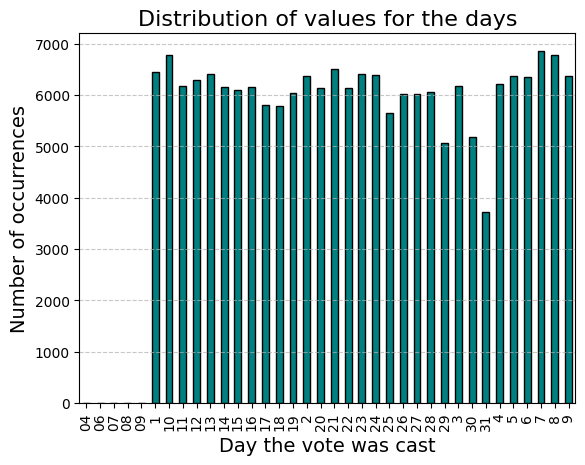

In [287]:
#Look at the distribution of the values for the days with histogram and order the values

ax = date_cleaned_data['day'].value_counts().sort_index().plot(kind='bar' ,  color='teal', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Day the vote was cast', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of values for the days', fontsize=16)

plt.show()

The values for the day also seem to be correct.

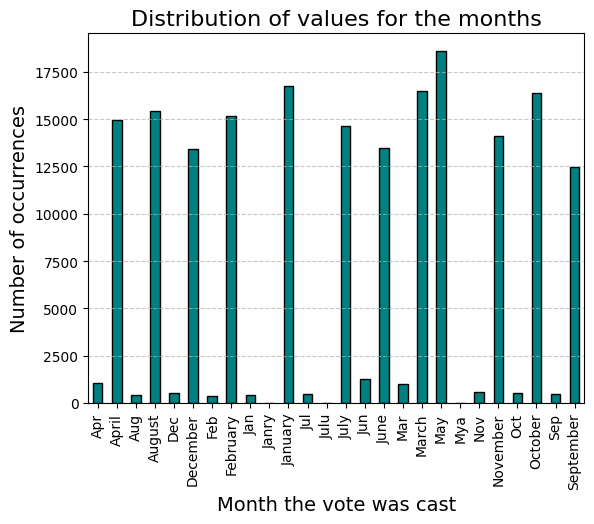

In [288]:
#Look at the distribution of the values for the months with histogram and order the values
ax = date_cleaned_data['month'].value_counts().sort_index().plot(kind='bar' , color='teal', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Month the vote was cast', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of values for the months', fontsize=16)

plt.show()

The dataset displays variations in the representation of specific months. For instance, the month of July is listed as 'Jul,' 'Julu,' and 'July'; similarly, October is noted as 'Oct' and 'October.'

In [289]:
#Map the values of the months to the full name of the month
month_map = { 
    "Apr" : "April",
    "April" : "April",
    "Aug" : "August",
    "August" : "August",
    "Dec" : "December",
    "December" : "December",
    "Feb" : "February",
    "February" : "February",
    "Jan" : "January",
    "Janry" : "January",
    "January" : "January",
    "Jul" : "July",
    "Julu" : "July",
    "July" : "July",
    "Jun" : "June",
    "June" : "June",
    "Mar" : "March",
    "March" : "March",
    "May" : "May",
    "Mya" : "May",
    "Nov" : "November",
    "November" : "November",
    "Oct" : "October",
    "October" : "October",
    "Sep" : "September",
    "September" : "September"
}

def correction_month (month) : 
    return month_map.get(month, month)

date_cleaned_data['month'] = date_cleaned_data['month'].apply(correction_month)
date_cleaned_data

,source,target,vote,result,year_election,date_vote,comment,hour,minute,day,month,year_vote
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.,23,13,19,April,2013
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--,01,04,20,April,2013
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.,23,43,19,April,2013
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...,00,11,20,April,2013
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit...",00,56,20,April,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support,02,51,2,September,2003
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.,23,45,26,November,2003
198272,Jiang,WhisperToMe,1,1,2003,None,Support. --,None,None,None,None,None
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....,05,38,5,December,2003


The values for the years seems also to be ok. 

In [290]:
date_cleaned_data['date_vote'] = pd.to_datetime(date_cleaned_data['day'].astype(str) + ' ' +
                            date_cleaned_data['month'].astype(str) + ' ' +
                            date_cleaned_data['year_vote'].astype(str) + ' ' +
                            date_cleaned_data['hour'].astype(str) + ':' +
                            date_cleaned_data['minute'].astype(str),
                            format='%d %B %Y %H:%M' , errors = 'coerce')

date_cleaned_data.drop(['hour', 'minute', 'day', 'month', 'year_vote'], axis=1, inplace=True)
date_cleaned_data

,source,target,vote,result,year_election,date_vote,comment
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support
198271,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.
198272,Jiang,WhisperToMe,1,1,2003,NaT,Support. --
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05 05:38:00,Support. Age has nothing to do with maturity....


### 2.4 Dive into the year_election values

In [297]:
year_elections_cleaned_data = date_cleaned_data.copy(deep=True)

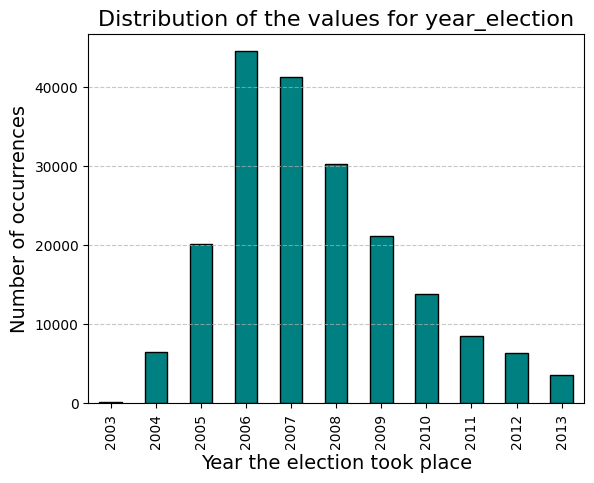

In [307]:
#Look at the distribution of the values for year_election
year_elections_cleaned_data['year_election'] = cleaned_df['year_election'].astype(int)


ax = year_elections_cleaned_data['year_election'].value_counts().sort_index().plot(kind='bar' , color='teal', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Year the election took place', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of the values for year_election', fontsize=16)

plt.show()

### 2.5 Dive into the vote and results values


In [300]:
vote_results_data_cleaned = year_elections_cleaned_data.copy(deep=True)

count    196613.000000
mean          0.524945
std           0.814283
min          -1.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: vote, dtype: float64


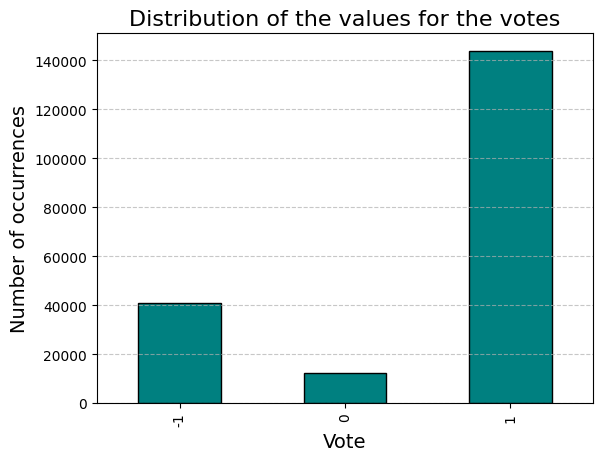

In [308]:
#Look at the distribution of the values for the vote
vote_results_data_cleaned['vote'] = vote_results_data_cleaned['vote'].astype(int)
vote_results_data_cleaned['result'] = vote_results_data_cleaned['result'].astype(int)

print(vote_results_data_cleaned['vote'].describe())
ax = vote_results_data_cleaned['vote'].value_counts().sort_index().plot(kind='bar' , color='teal', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Vote', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of the values for the votes', fontsize=16)

plt.show()

In [309]:
value_perc_vote = vote_results_data_cleaned['vote'].value_counts(normalize=True) * 100

# Print the percentages
print("Percentage of Each Unique Value in vote:")
print(value_perc_vote)

Percentage of Each Unique Value in vote:
vote
 1    73.178274
-1    20.683780
 0     6.137946
Name: proportion, dtype: float64


count    196613.000000
mean          0.246337
std           0.969187
min          -1.000000
25%          -1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: result, dtype: float64


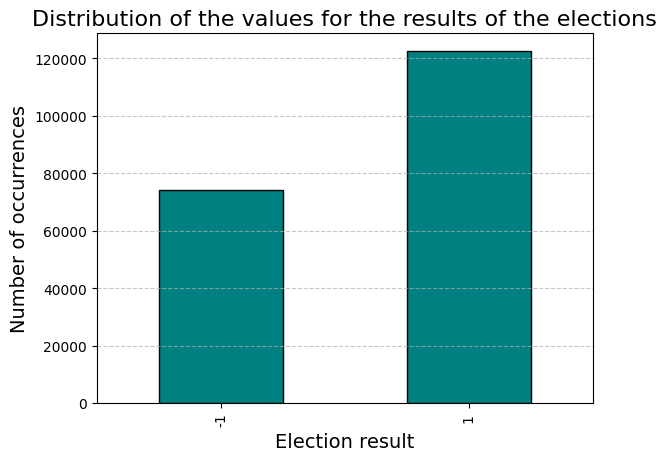

In [310]:
#Look at the distribution of the values for the result
print(vote_results_data_cleaned['result'].describe())
ax = vote_results_data_cleaned['result'].value_counts().sort_index().plot(kind='bar' , color='teal', edgecolor='black')

plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Election result', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of the values for the results of the elections', fontsize=16)

plt.show()
plt.show()

In [311]:
value_perc_result = vote_results_data_cleaned['result'].value_counts(normalize=True) * 100

# Print the percentages
print("Percentage of Each Unique Value in result:")
print(value_perc_result)

Percentage of Each Unique Value in result:
result
 1    62.316836
-1    37.683164
Name: proportion, dtype: float64


### 2.6 Dive into comments

The percentage of empty comments is 2.81%


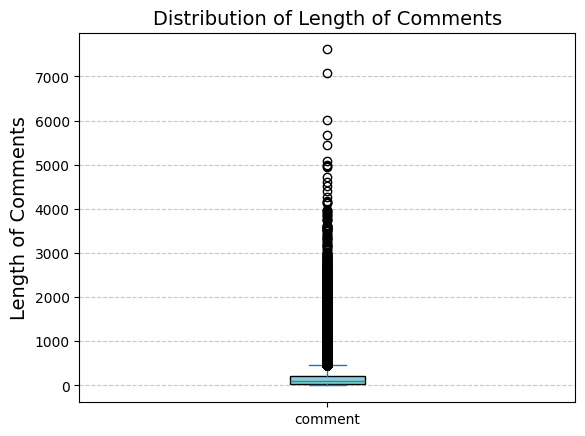

In [319]:
#Look at the proportion of empty comments
print(f'The percentage of empty comments is {vote_results_data_cleaned[vote_results_data_cleaned.comment == ""]["comment"].count()/vote_results_data_cleaned["comment"].count() * 100:.2f}%')

#Look at the disribution of the length of the comments
ax = vote_results_data_cleaned['comment'].str.len().plot(kind='box', patch_artist=True, boxprops=dict(facecolor='skyblue'))
ax.set_title('Distribution of Length of Comments', fontsize=14)
ax.set_ylabel('Length of Comments', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [321]:
cleaned_df = vote_results_data_cleaned.copy(deep=True)

#Store the cleaned dataframe in a csv file
cleaned_df.to_csv('../data/wiki-RfA-cleaned.csv', index=False)

## 3. Voting results analysis

cleaned_df 

In [322]:
analysis_df = pd.read_csv('../data/wiki-RfA-cleaned.csv')

In [323]:
analysis_df

,source,target,vote,result,year_election,date_vote,comment
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
196608,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support
196609,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.
196610,Jiang,WhisperToMe,1,1,2003,NaN,Support. --
196611,Pakaran,WhisperToMe,1,1,2003,2003-12-05 05:38:00,Support. Age has nothing to do with maturity....


In [117]:
#We compute here different statistics
multiple_elections = cleaned_df.groupby(['target' , 'result', 'year_election']).apply(lambda x : pd.Series({
    'number_of_votes' : len(x['source']), 
    'ratio_positive_votes' : x[x.vote == 1]['vote'].sum() / len(x.source), 
    'average_comment_length' : x['comment'].str.len().mean(),
})).reset_index()

In [123]:
#Look wether we have multiple rows where the target and result are the same
multiple_elections[multiple_elections.duplicated(subset=['target', 'result'], keep=False)]


,target,result,year_election,number_of_votes,ratio_positive_votes,average_comment_length
18,9cds,-1,2005,12.0,0.083333,125.083333
19,9cds,-1,2006,34.0,0.382353,189.764706
22,A Link to the Past,-1,2005,30.0,0.200000,188.066667
23,A Link to the Past,-1,2006,75.0,0.440000,162.520000
35,ACBest,-1,2007,17.0,0.117647,289.529412
...,...,...,...,...,...,...
3795,ZooPro,-1,2009,17.0,0.117647,244.529412
3796,ZooPro,-1,2010,14.0,0.071429,381.214286
3797,ZooPro,-1,2011,24.0,0.083333,378.791667
3808,^demon,1,2007,83.0,0.987952,91.963855


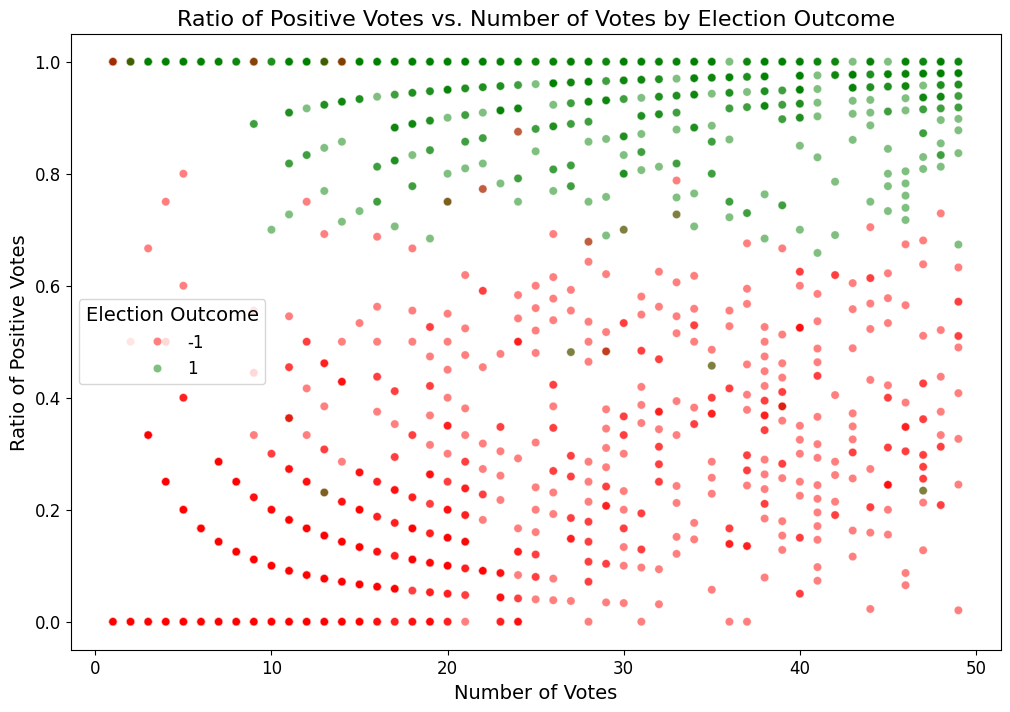

In [101]:
#Plot the ratio of positive votes for each election, an election is identified by the year of the result and the target
# Set the figure size
plt.figure(figsize=(12, 8))  # Adjust the size as needed

# Create the scatter plot
sns.scatterplot(x='number_of_votes', 
                y='ratio_positive_votes', 
                hue='result', 
                data=multiple_elections[multiple_elections['number_of_votes'] < 50],
                palette=['red', 'green'],  # Optional: Specify custom colors
                alpha=0.5)  # Optional: Adjust transparency

# Enhance plot aesthetics
plt.title('Ratio of Positive Votes vs. Number of Votes by Election Outcome', fontsize=16)
plt.xlabel('Number of Votes', fontsize=14)
plt.ylabel('Ratio of Positive Votes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Election Outcome', fontsize=12, title_fontsize=14)

plt.show()


Seems like there is a specific threshold for the percentage of positive votes for an election to be successfull. 

In [111]:
#Compute the correlation between the ratio of positive votes and the outcome of the election
stats.pearsonr(multiple_elections['ratio_positive_votes'], multiple_elections['result'])

PearsonRResult(statistic=0.8809922293325008, pvalue=0.0)

Very high correlation between the ration of positive votes and the result of the election

<Axes: xlabel='result', ylabel='ratio_positive_votes'>

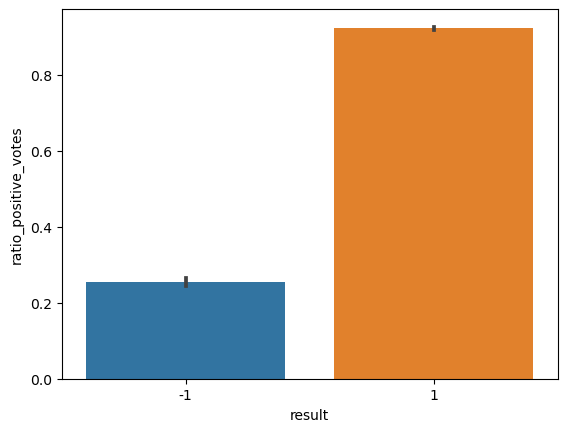

In [31]:
sns.barplot( x= 'result' , y = 'ratio_positive_votes' , data = multiple_elections)

/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


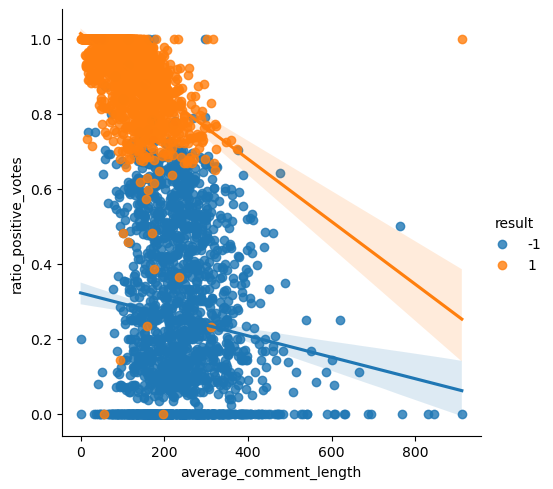

In [32]:
sns.lmplot(x = 'average_comment_length' , y = 'ratio_positive_votes' , data = multiple_elections , hue = 'result')

In [33]:
#Compute the correlation between the outcome of the vote and the ratio of positive votes
multiple_elections['result'].corr(multiple_elections['ratio_positive_votes'])

#Compute the correlation between the outcome of the vote and the average length of the comment
multiple_elections['result'].corr(multiple_elections['average_comment_length'])


-0.615878234971494

## 4. Number of votes analysis

In [34]:
multiple_elections['election_year'].unique().sort()

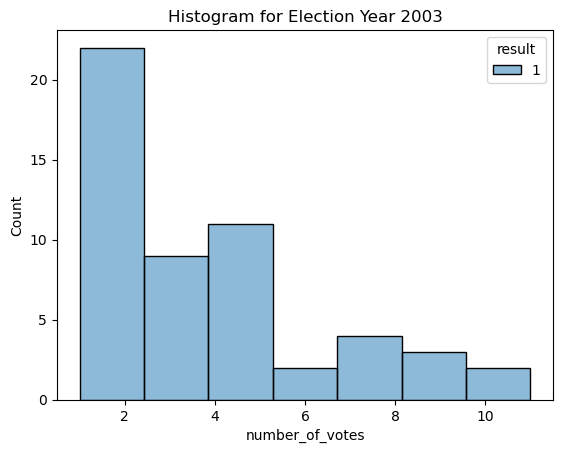

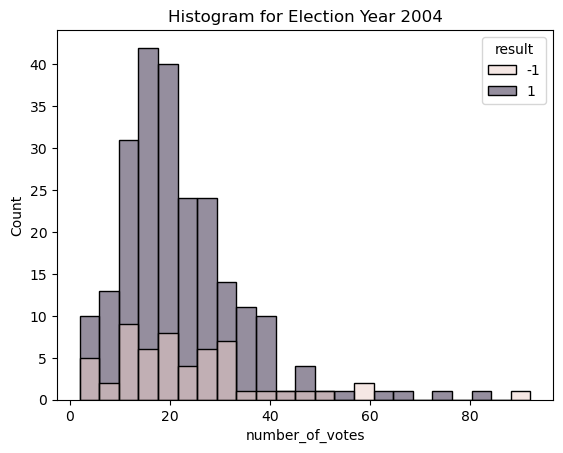

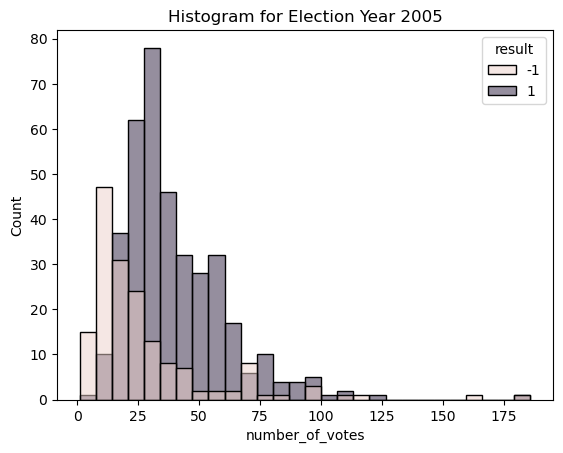

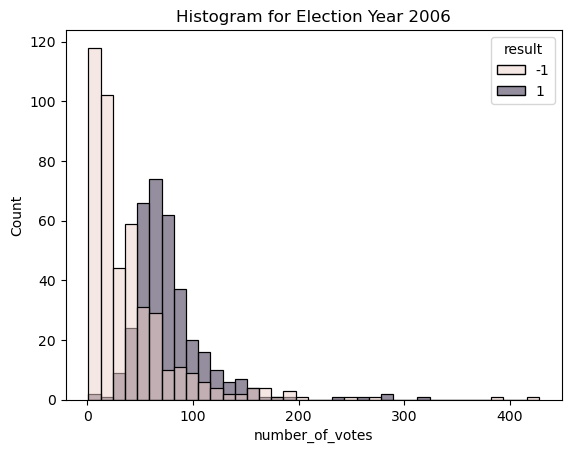

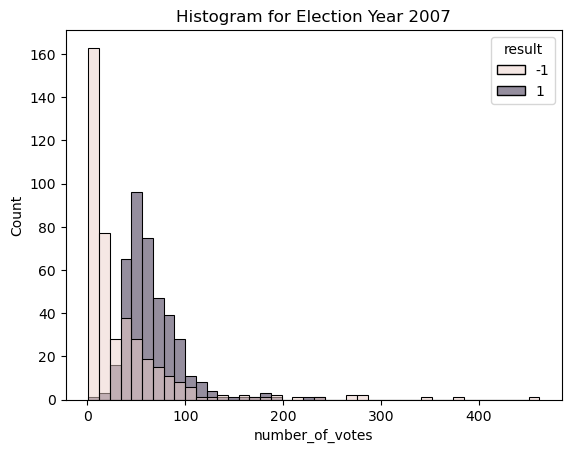

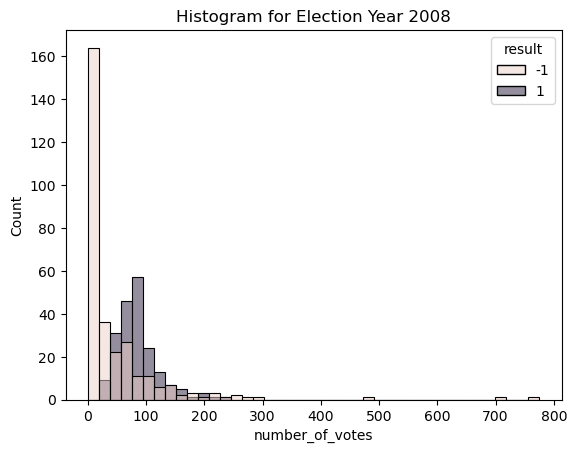

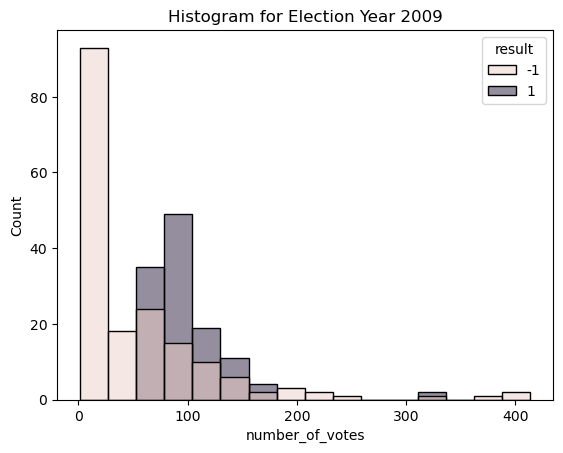

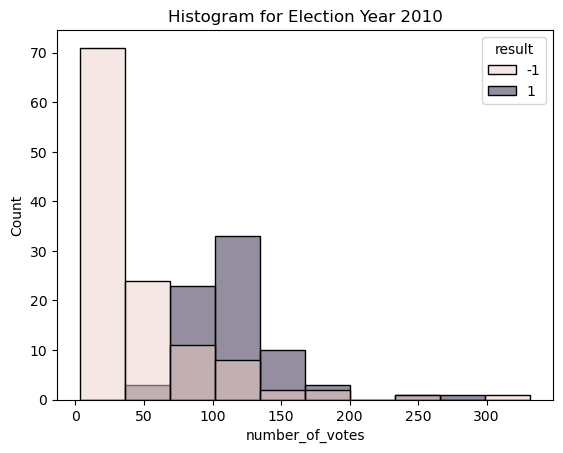

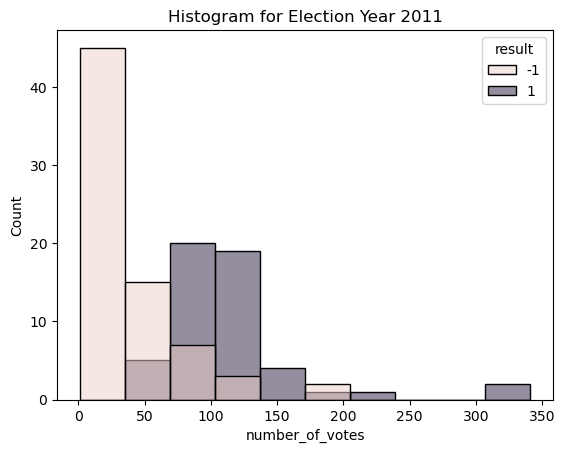

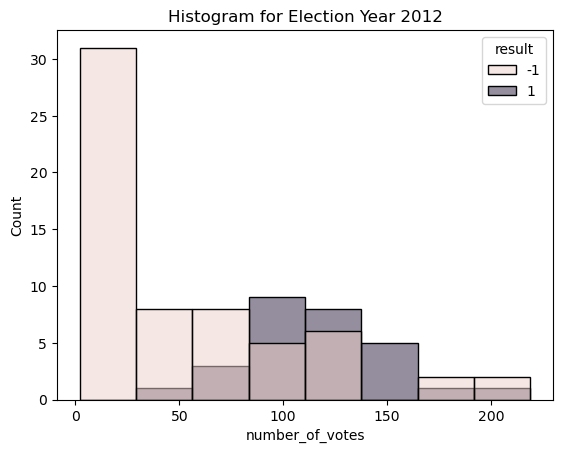

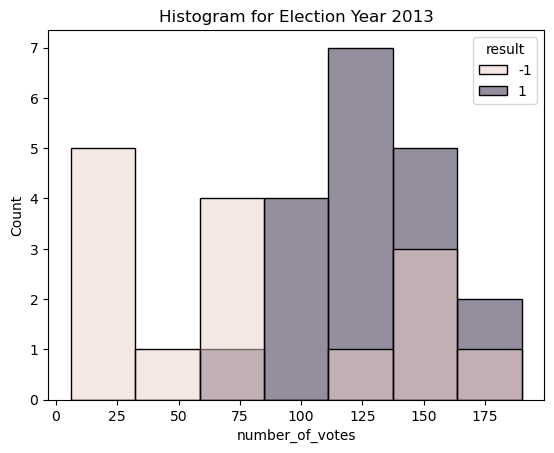

In [35]:
# Assuming 'election_year' is of type int
for year in sorted(multiple_elections['election_year'].unique()):
    data_subset = multiple_elections[multiple_elections['election_year'] == year]
    
    sns.histplot(x='number_of_votes', data=data_subset, hue='result', log_scale=(False, False))
    plt.title(f'Histogram for Election Year {int(year)}')
    plt.show()

<Axes: xlabel='number_of_votes', ylabel='Count'>

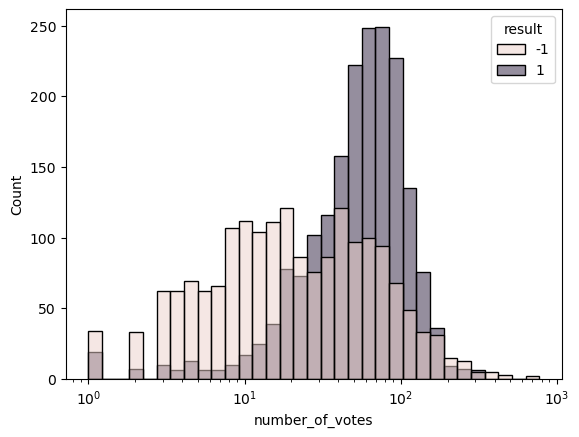

In [36]:
sns.histplot(x = 'number_of_votes', data = multiple_elections , hue = 'result', log_scale= (True, False))

In [37]:
new_df.groupby(["target", "result"])["source"].count().median()

41.0

In [38]:
new_df.groupby(["target", "result"])["source"].count().mean()

52.75395760665415